## Geolocation data

In [1]:
import folium
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist
from sklearn import metrics
from sklearn.cluster import KMeans

import fetch
from fetch.utils import json_or_fetch

In [2]:
df_company = pd.read_csv('data/2_cleaned_data.csv', index_col=0)

In [3]:
geo_data = json_or_fetch(df_company['address'], fetch.geolocation, 'data/geo_data.json')

In [4]:
# unzips the coordinate tuples
lats, lons = zip(*geo_data.values())
df_company['latitude'] = lats
df_company['longitude'] = lons

In [5]:
df_company.to_csv('data/3_geolocation.csv')

In [6]:
first_coords = df_company.iloc[0][['latitude', 'longitude']]
m = folium.Map(location=first_coords, zoom_start=12)
for idx, row in df_company.iterrows():
    folium.Marker(row[['latitude', 'longitude']], popup=f"<b>{row['name']}</b> <i>{row['industrydesc']}</i>").add_to(m)
m.save('renders/map.html')
m

### Location clustering

In [7]:
coordinates = df_company[['latitude', 'longitude']]
coordinates

,latitude,longitude
Dynatest A/S,55.729930,12.464800
"Eriksholm Research Centre, Oticon",55.757949,12.228728
Formpipe,55.733204,12.391164
Novo Nordisk,55.754555,12.455185
PFA,55.708655,12.591288
Topdanmark,55.734142,12.380579
KMD A/S,55.736130,12.393105
NorthTech ApS,55.674321,12.591612
Alpha Solutions,55.682038,12.583964
Dafolo,57.445530,10.493744


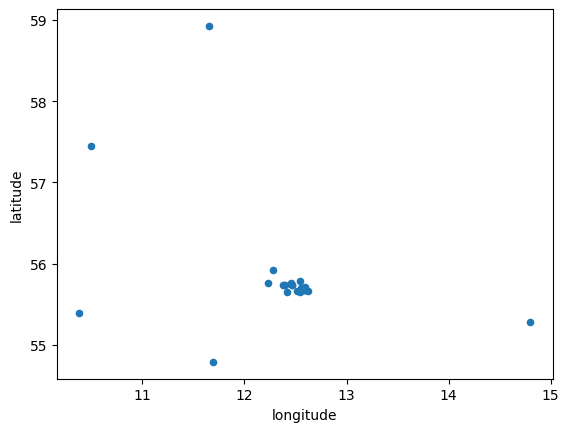

In [8]:
coordinates.plot.scatter(x='longitude', y='latitude')
plt.show()

#### K-Means

In [9]:
distortions = []
K = range(1, 10)
for k in K:
    kmeans = KMeans(n_clusters=k, n_init=10)
    kmeans.fit(coordinates)
    # calculate distortion and append to list
    distortions.append(sum(np.min(cdist(coordinates, kmeans.cluster_centers_, 'euclidean'), axis=1)) / coordinates.shape[0])
print(distortions)

[0.6267281104776248, 0.40489858010952057, 0.3410088889446933, 0.21761471661468135, 0.1445298664563251, 0.08481657325305729, 0.0455992033243183, 0.035291375896829076, 0.0282859692089631]


In [10]:
def plot_distortion_elbow():
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()

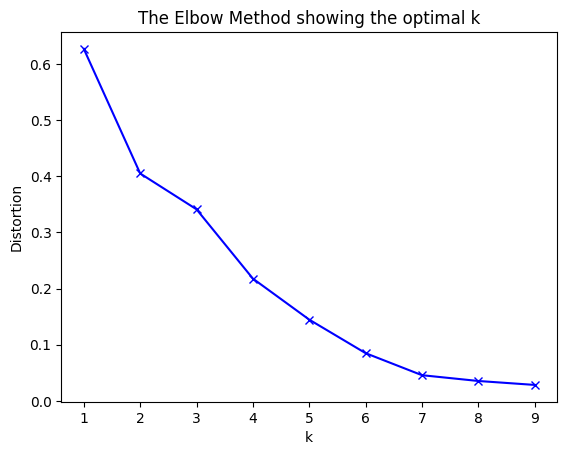

In [11]:
plot_distortion_elbow()

In [12]:
scores = []
K = range(2, 10)
for k in K:
    kmeans = KMeans(n_clusters=k, n_init=10)
    kmeans.fit(coordinates)
    # default metric for silhouette is euclidean
    scores.append(metrics.silhouette_score(coordinates, kmeans.labels_, sample_size=coordinates.shape[0]))
print(scores)

[0.7801497538704936, 0.7650828753193406, 0.7632453098125664, 0.7351928761714561, 0.7036386647187786, 0.4365649822576134, 0.4586726452294322, 0.4363252934937482]


In [13]:
num_clusters = 4

In [14]:
kmeans = KMeans(n_clusters=num_clusters, init='k-means++', n_init=20)
kmeans.fit(coordinates)

KMeans(n_clusters=4, n_init=20)

In [15]:
kmeans.labels_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 0, 1, 1, 1, 1, 1, 1, 3, 0, 1, 2,
       1, 1, 1])

In [16]:
kmeans.cluster_centers_

array([[55.0921295 , 11.036604  ],
       [55.716732  , 12.488028  ],
       [58.18649555, 11.07271185],
       [55.274825  , 14.800772  ]])

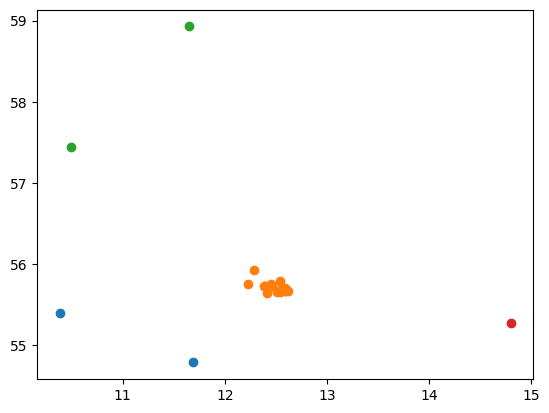

In [17]:
for i in range(num_clusters):
    cluster = coordinates[kmeans.labels_ == i]
    plt.scatter(cluster['longitude'], cluster['latitude'], label=f'Cluster {i}')

If you want to plot the clusters separately, then you should consider supplying the min and max values to the plot, so that they are mapped unto the same position as they would be in the plot with all of them.

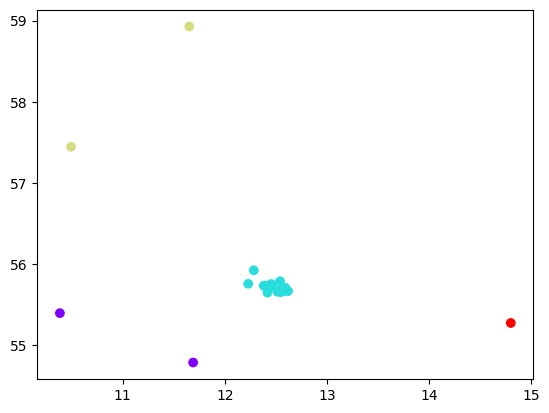

In [18]:
# Another way to plot them all at once
plt.scatter(coordinates['longitude'], coordinates['latitude'], c=kmeans.labels_, cmap='rainbow')
# different cmap are colour schemes. See https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html
# 'viridis' is a good one too

And now with the boundaries of the clusters.

In [19]:
x_min, x_max = coordinates['longitude'].min(), coordinates['longitude'].max()
y_min, y_max = coordinates['latitude'].min(), coordinates['latitude'].max()

In [20]:
# we need a grid of points for drawing a smooth border between clusters
# define step size of the mesh 
step_size = 0.01

# we need to cover all points of our data
# create a grid out of an array of X values and an array of y values
x_coord = np.arange(x_min, x_max, step_size)
y_coord = np.arange(y_min, y_max, step_size)

# meshgrid() creates a matrix of coordinates from the two vectors of coordinates
x_vals, y_vals = np.meshgrid(x_coord, y_coord)

In [21]:
# Predict cluster labels for all the points on the grid 
# ravel() returns 1D-array
xx = x_vals.ravel()
yy = y_vals.ravel()

# np.c_ concatenates the arguments
labels = kmeans.predict(np.c_[xx,yy])
labels = labels.reshape(x_vals.shape)

c:\Python39\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


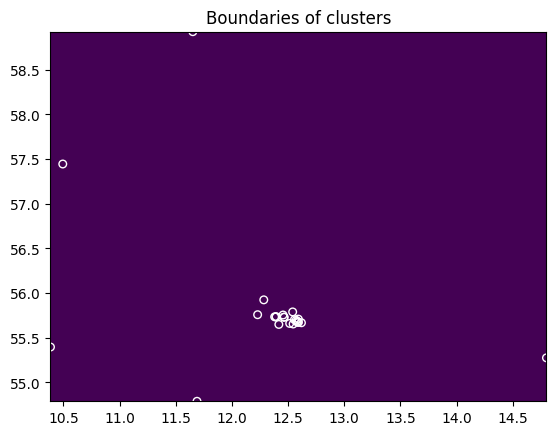

In [22]:
# Plot the clusters
# create new plot area
plt.figure()
# clear the plot area
plt.clf()

plt.title('Boundaries of clusters')

# plot the frame
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

# plot the clusters 
plt.imshow(labels, interpolation='nearest',
           extent=(x_vals.min(), x_vals.max(), y_vals.min(), y_vals.max()),
           cmap='viridis', aspect='auto')
# plot the points as they belong to the clusters
plt.scatter(coordinates['longitude'], coordinates['latitude'], marker='o', facecolors='none', edgecolors='white', s=30) 

# plot the centroids
centers = kmeans.cluster_centers_
plt.scatter(centers[:,0], centers[:,1],  s=200, linewidths=2, color='yellow', marker='*', zorder=3, facecolors='black')

# annotate the centroids
for i, center in enumerate(centers):
    plt.annotate(i, center+[0.0,1.0], 
                 size=15, zorder=1, color='yellow', weight='bold', 
                 horizontalalignment='center', verticalalignment='center',) 
plt.show()

With some clusters only having one node, it looks ugly as hell, because those don't seem to show.

Even with 4 clusters to some are grouped together, it looks extremely messed up.